In [1]:
# -*- coding: utf-8 -*-
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import os

In [5]:
# Set random seed
tf.random.set_seed(42)
np.random.seed(42)

# === Data Paths ===
train_dir = '/content/drive/MyDrive/train'
val_dir = '/content/drive/MyDrive/val'
test_dir = '/content/drive/MyDrive/val'
img_size = (224, 224)
batch_size = 32

In [6]:
# === Data Augmentation ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 697 images belonging to 9 classes.
Found 181 images belonging to 9 classes.
Found 181 images belonging to 9 classes.


In [7]:
# === Class Weights ===
labels = train_gen.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

In [8]:
# === Build Model ===
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True  # Unfreeze all layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# === Callbacks ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-6)

In [10]:
# === Train ===
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 720s 28s/step - accuracy: 0.2113 - loss: 2.4315 - val_accuracy: 0.4144 - val_loss: 1.6041 - learning_rate: 1.0000e-04
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 546s 25s/step - accuracy: 0.6306 - loss: 1.1169 - val_accuracy: 0.5249 - val_loss: 1.3003 - learning_rate: 1.0000e-04
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 571s 26s/step - accuracy: 0.7561 - loss: 0.6954 - val_accuracy: 0.6077 - val_loss: 1.1616 - learning_rate: 1.0000e-04
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 537s 25s/step - accuracy: 0.7746 - loss: 0.6048 - val_accuracy: 0.6409 - val_loss: 1.0738 - learning_rate: 1.0000e-04
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 535s 24s/step - accuracy: 0.8429 - loss: 0.4714 - val_accuracy: 0.6740 - val_loss: 0.9532 - learning_rate: 1.0000e-04
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 533s 24s/step - accuracy: 0.8786 - loss: 0.3715 - val_accuracy: 0.7182 - val_loss: 0.8194 - learning_rate: 1.0000e-04
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 564s 25s/step - accuracy: 

In [16]:
# === Evaluate ===
loss, acc = model.evaluate(test_gen)
print(f"Final Test Accuracy: {acc * 100:.2f}%")

181/181 ━━━━━━━━━━━━━━━━━━━━ 30s 167ms/step - accuracy: 0.7827 - loss: 0.6292
Final Test Accuracy: 81.77%


181/181 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step


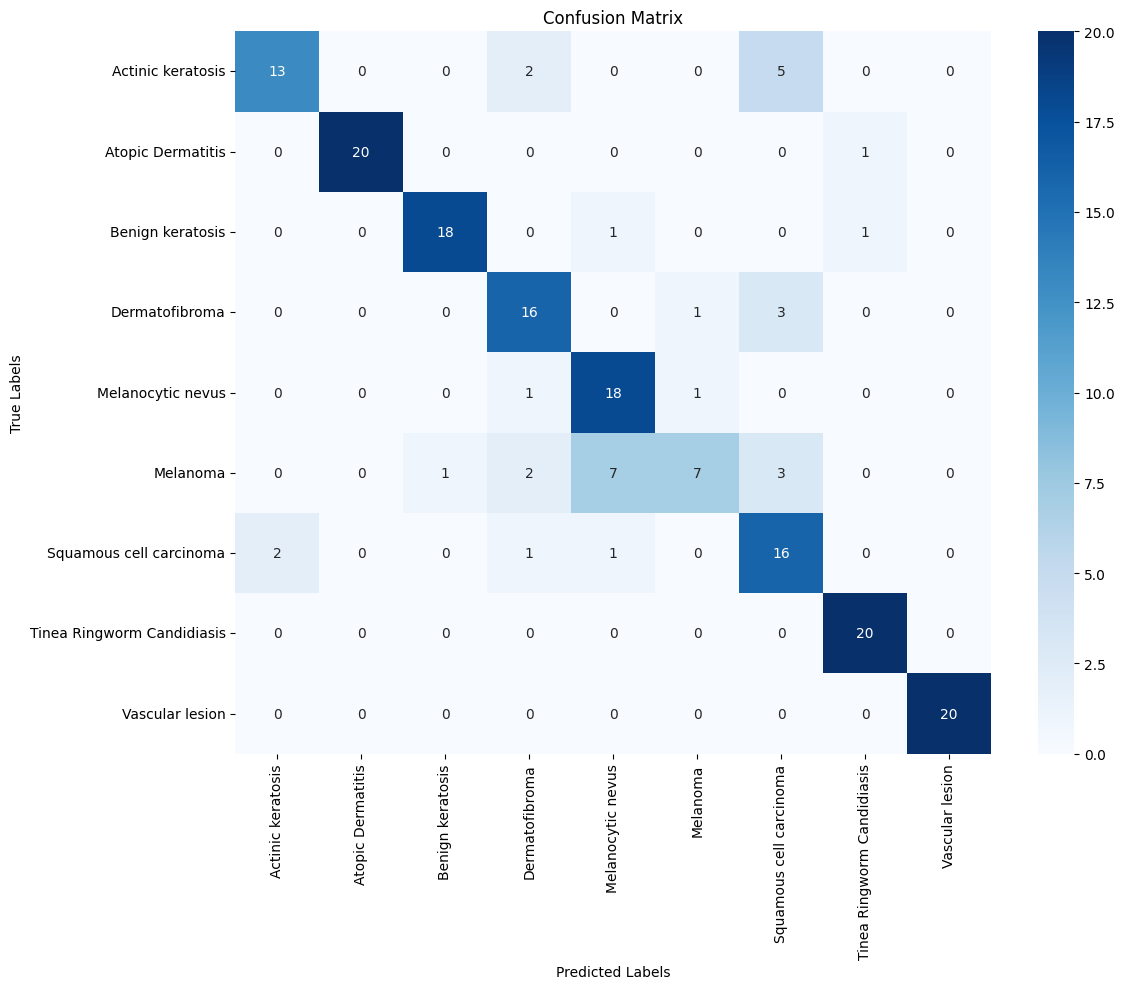

Classification Report:

                            precision    recall  f1-score   support

         Actinic keratosis       0.87      0.65      0.74        20
         Atopic Dermatitis       1.00      0.95      0.98        21
          Benign keratosis       0.95      0.90      0.92        20
            Dermatofibroma       0.73      0.80      0.76        20
         Melanocytic nevus       0.67      0.90      0.77        20
                  Melanoma       0.78      0.35      0.48        20
   Squamous cell carcinoma       0.59      0.80      0.68        20
Tinea Ringworm Candidiasis       0.91      1.00      0.95        20
           Vascular lesion       1.00      1.00      1.00        20

                  accuracy                           0.82       181
                 macro avg       0.83      0.82      0.81       181
              weighted avg       0.83      0.82      0.81       181



In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Get predictions
Y_pred = model.predict(test_gen, steps=test_gen.samples)
y_pred = np.argmax(Y_pred, axis=1)

# Step 2: True labels
y_true = test_gen.classes

# Step 3: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_gen.class_indices.keys())

# Step 4: Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Optional: Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

In [15]:
# === Save Model ===
model.save('/content/drive/MyDrive/final_project/DenseNet_81PercentageAccuracy.h5')